In [ ]:
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation
import matplotlib.patches as mpatches
from lightning_threshold_functions import *

In [19]:
rainband_shear_timebin_joined = pd.read_csv("../data_pipeline/data/rainband_shear_timebin_joined.csv")
rainband_shear_timebin_joined = pl.from_pandas(rainband_shear_timebin_joined)

In [20]:
rainband_shear_timebin_joined.head()

shape: (5, 20)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ time_bin  ┆ shear_qua ┆ storm_cod ┆ lightning ┆ … ┆ 24_hour_k ┆ 24_hour_p ┆ TC_Catego ┆ Intensif │
│ ---       ┆ d         ┆ e         ┆ _count    ┆   ┆ nots_diff ┆ ressure_d ┆ ry        ┆ ication_ │
│ str       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ iff       ┆ ---       ┆ Category │
│           ┆ str       ┆ str       ┆ i64       ┆   ┆ f64       ┆ ---       ┆ str       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆ f64       ┆           ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2010-06-2 ┆ DL        ┆ ATL_10_1  ┆ 75        ┆ … ┆ 25.0      ┆ -7.0      ┆ Unidentif ┆ Intensif │
│ 5         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ied       ┆ ying     │
│ 15:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ DR        ┆ ATL_10_1  ┆ 11        ┆ … ┆ 25.0      ┆ -7.0      ┆ Unidentif ┆ Intensif │
│ 5         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ied       ┆ ying     │
│ 15:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ UL        ┆ ATL_10_1  ┆ 0         ┆ … ┆ 25.0      ┆ -7.0      ┆ Unidentif ┆ Intensif │
│ 5         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ied       ┆ ying     │
│ 15:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ UR        ┆ ATL_10_1  ┆ 26        ┆ … ┆ 25.0      ┆ -7.0      ┆ Unidentif ┆ Intensif │
│ 5         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ied       ┆ ying     │
│ 15:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ DL        ┆ ATL_10_1  ┆ 2         ┆ … ┆ 25.0      ┆ -7.0      ┆ Unidentif ┆ Intensif │
│ 5         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ied       ┆ ying     │
│ 15:30:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [21]:
# import data from csv file
rainband_shear_timebin_joined = rainband_shear_timebin_joined.with_columns(
    pl.col("time_bin").str.strptime(pl.Datetime).alias("time_bin"),
    pl.col("storm_code").str.extract(r"^(.*?)_", 1).alias("basin"),
    pl.col("lightning_count").log1p().alias("log_lightning_count"),
    pl.when(pl.col("pressure") == 0)
    .then(None)  # Replace 0 with None -> 0 is not possible, treat these as null but don't remove row bc the wind speed value is valid
    .otherwise(pl.col("pressure"))
    .alias("pressure")  # Keep the column name as "pressure"
)
rainband_shear_timebin_joined = rainband_shear_timebin_joined.with_columns(
    pl.when(pl.col("TC_Category") == "Unidentified")
    .then(pl.lit("0")) # Replace "unidentified" with 0 for current category
    .otherwise(pl.col("TC_Category"))
    .alias("TC_Category")
)
rainband_shear_timebin_joined = rainband_shear_timebin_joined.rename({"Intensification_Category":"Intensification_Category_5", "TC_Category":"Current_Category"})
rainband_shear_timebin_joined.head()


shape: (5, 21)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ time_bin  ┆ shear_qua ┆ storm_cod ┆ lightning ┆ … ┆ 24_hour_p ┆ Current_C ┆ Intensifi ┆ log_ligh │
│ ---       ┆ d         ┆ e         ┆ _count    ┆   ┆ ressure_d ┆ ategory   ┆ cation_Ca ┆ tning_co │
│ datetime[ ┆ ---       ┆ ---       ┆ ---       ┆   ┆ iff       ┆ ---       ┆ tegory_5  ┆ unt      │
│ μs]       ┆ str       ┆ str       ┆ i64       ┆   ┆ ---       ┆ str       ┆ ---       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆           ┆ str       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2010-06-2 ┆ DL        ┆ ATL_10_1  ┆ 75        ┆ … ┆ -7.0      ┆ 0         ┆ Intensify ┆ 4.330733 │
│ 5         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ing       ┆          │
│ 15:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ DR        ┆ ATL_10_1  ┆ 11        ┆ … ┆ -7.0      ┆ 0         ┆ Intensify ┆ 2.484907 │
│ 5         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ing       ┆          │
│ 15:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ UL        ┆ ATL_10_1  ┆ 0         ┆ … ┆ -7.0      ┆ 0         ┆ Intensify ┆ 0.0      │
│ 5         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ing       ┆          │
│ 15:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ UR        ┆ ATL_10_1  ┆ 26        ┆ … ┆ -7.0      ┆ 0         ┆ Intensify ┆ 3.295837 │
│ 5         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ing       ┆          │
│ 15:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ DL        ┆ ATL_10_1  ┆ 2         ┆ … ┆ -7.0      ┆ 0         ┆ Intensify ┆ 1.098612 │
│ 5         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ing       ┆          │
│ 15:30:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [22]:
# Mapping intensification bins into 3 category instead of 5
category_mapping = {
    "Rapidly Weakening": "Weakening",
    "Weakening": "Weakening",
    "Neutral": "Neutral",
    "Intensifying": "Intensifying",
    "Rapidly Intensifying": "Intensifying"
}

# Apply mapping to create new column
rainband_shear_timebin_joined = rainband_shear_timebin_joined.with_columns(
    rainband_shear_timebin_joined["Intensification_Category_5"].replace(category_mapping).alias("Intensification_Category_3")
)

rainband_shear_timebin_joined.head()

shape: (5, 22)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ time_bin  ┆ shear_qua ┆ storm_cod ┆ lightning ┆ … ┆ Current_C ┆ Intensifi ┆ log_light ┆ Intensif │
│ ---       ┆ d         ┆ e         ┆ _count    ┆   ┆ ategory   ┆ cation_Ca ┆ ning_coun ┆ ication_ │
│ datetime[ ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ tegory_5  ┆ t         ┆ Category │
│ μs]       ┆ str       ┆ str       ┆ i64       ┆   ┆ str       ┆ ---       ┆ ---       ┆ _3       │
│           ┆           ┆           ┆           ┆   ┆           ┆ str       ┆ f64       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2010-06-2 ┆ DL        ┆ ATL_10_1  ┆ 75        ┆ … ┆ 0         ┆ Intensify ┆ 4.330733  ┆ Intensif │
│ 5         ┆           ┆           ┆           ┆   ┆           ┆ ing       ┆           ┆ ying     │
│ 15:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ DR        ┆ ATL_10_1  ┆ 11        ┆ … ┆ 0         ┆ Intensify ┆ 2.484907  ┆ Intensif │
│ 5         ┆           ┆           ┆           ┆   ┆           ┆ ing       ┆           ┆ ying     │
│ 15:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ UL        ┆ ATL_10_1  ┆ 0         ┆ … ┆ 0         ┆ Intensify ┆ 0.0       ┆ Intensif │
│ 5         ┆           ┆           ┆           ┆   ┆           ┆ ing       ┆           ┆ ying     │
│ 15:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ UR        ┆ ATL_10_1  ┆ 26        ┆ … ┆ 0         ┆ Intensify ┆ 3.295837  ┆ Intensif │
│ 5         ┆           ┆           ┆           ┆   ┆           ┆ ing       ┆           ┆ ying     │
│ 15:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ DL        ┆ ATL_10_1  ┆ 2         ┆ … ┆ 0         ┆ Intensify ┆ 1.098612  ┆ Intensif │
│ 5         ┆           ┆           ┆           ┆   ┆           ┆ ing       ┆           ┆ ying     │
│ 15:30:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [23]:
storm_names = rainband_shear_timebin_joined[["storm_code", "storm_name"]].unique()

In [24]:
# Filter out data where wind is less than 40 knots for threshold analysis
analysis_data = rainband_shear_timebin_joined.filter(pl.col("knots") >= 40)
# Convert polars dataframe to pandas for application of functions
pd_data = analysis_data.to_pandas()

# Apply functions to data, including bins with 0 lightning
bursts_w_0 = apply_individual_thresholds(pd_data)

tc_summary_w_0 = create_tc_summary(bursts_w_0)
tc_summary_w_0.head(30)

#Get mean threshold value for each of the 6 options
# tc_summary_w_0_mean = tc_summary_w_0.drop(columns=(["storm_code",'shear_quad'])).mean()
# print(tc_summary_w_0_mean[["mad1_threshold", "mad2_threshold", "iqr1_threshold", "iqr2_threshold", "logn1_threshold", "logn2_threshold"]])
# # Get median threshold value for each of the 6 options
# tc_summary_w_0_median = tc_summary_w_0.drop(columns=(["storm_code",'shear_quad'])).median()
# print(tc_summary_w_0_median[["mad1_threshold", "mad2_threshold", "iqr1_threshold", "iqr2_threshold", "logn1_threshold", "logn2_threshold"]])

# # Get mean threshold value for each of the 6 options
# tc_summary_w_0_mean = tc_summary_w_0.drop(columns=(["storm_code",'shear_quad'])).mean()
# print(tc_summary_w_0_mean[["mad1_threshold", "mad2_threshold", "iqr1_threshold", "iqr2_threshold", "logn1_threshold", "logn2_threshold"]])
# # Get median threshold value for each of the 6 options
# tc_summary_w_0_median = tc_summary_w_0.drop(columns=(["storm_code",'shear_quad'])).median()
# print(tc_summary_w_0_median[["mad1_threshold", "mad2_threshold", "iqr1_threshold", "iqr2_threshold", "logn1_threshold", "logn2_threshold"]])

c:\Users\user\Desktop\GitHub\Lightning_Analysis_NWRA\lightning_burst_identification\lightning_threshold_functions.py:145: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  bursts = df.groupby(["storm_code"]).apply(detect_bursts_iqr)
c:\Users\user\Desktop\GitHub\Lightning_Analysis_NWRA\lightning_burst_identification\lightning_threshold_functions.py:147: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
0    ATL_10_1          121           68        3.465736        4.158883   
1   ATL_10_11          779          779        0.000000        0.000000   
2   ATL_10_12          230          230        0.000000        0.000000   
3   ATL_10_13          175          175        0.000000        0.000000   
4   ATL_10_14           51           51        0.000000        0.000000   
5   ATL_10_17          174          174        0.000000        0.000000   
6   ATL_10_18          200          153        3.465736        4.158883   
7   ATL_10_19            0            0        8.816516       10.534168   
8   ATL_10_20           40           40        0.000000        0.000000   
9   ATL_10_21           69           21        5.493061        6.591674   
10   ATL_10_6          463          463        0.000000        0.000000   
11   ATL_10_7          794          794        0.000000        0.000000   
12  ATL_11_12          767          767        0.000000        0.000000   
13  ATL_11_14          717          717        0.000000        0.000000   
14  ATL_11_16          673          673        0.000000        0.000000   
15  ATL_11_17          399          399        0.000000        0.000000   
16  ATL_11_18          279          279        0.000000        0.000000   
17   ATL_11_9            3            0        5.493061        6.591674   
18  ATL_12_11          196          196        0.000000        0.000000   
19  ATL_12_12          891          891        0.000000        0.000000   
20  ATL_12_13          275          275        0.000000        0.000000   
21  ATL_12_14          419          419        0.000000        0.000000   
22  ATL_12_17           99           40        3.465736        4.158883   
23  ATL_12_18           49           26        3.465736        4.158883   
24   ATL_12_3           55           55        0.000000        0.000000   
25   ATL_12_5            0            0        6.931472        8.317766   
26   ATL_12_8          133          133        0.000000        0.000000   
27   ATL_12_9           34            3        5.493061        6.591674   
28  ATL_13_10          142          142        0.000000        0.000000   
29   ATL_13_9          223          223        0.000000        0.000000   

    iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
0             0            0        5.914525        7.393156            31   
1           227          130        2.772589        3.465736           140   
2           230          230        0.000000        0.000000            77   
3            25            3        4.217775        5.272218            27   
4            51           51        0.000000        0.000000            31   
5           174          174        0.000000        0.000000            41   
6             0            0        7.533895        9.417369            24   
7             0            0        6.883849        8.604811             7   
8            29           27        1.386294        1.732868             9   
9            58            4        5.780744        7.225929            71   
10          186          138        2.197225        2.746531           107   
11           60            4        4.795791        5.994738            92   
12          206          118        2.772589        3.465736           130   
13           64            1        5.888878        7.361097            93   
14          246          141        3.218876        4.023595           124   
15          399          399        0.000000        0.000000           146   
16           33            1        4.839296        6.049120            37   
17            2            0        5.545177        6.931472            35   
18           97           91        1.386294        1.732868            53   
19          188           93        3.218876        4.023595           139   
20          275          275        0.0

<Figure size 1000x500 with 0 Axes>

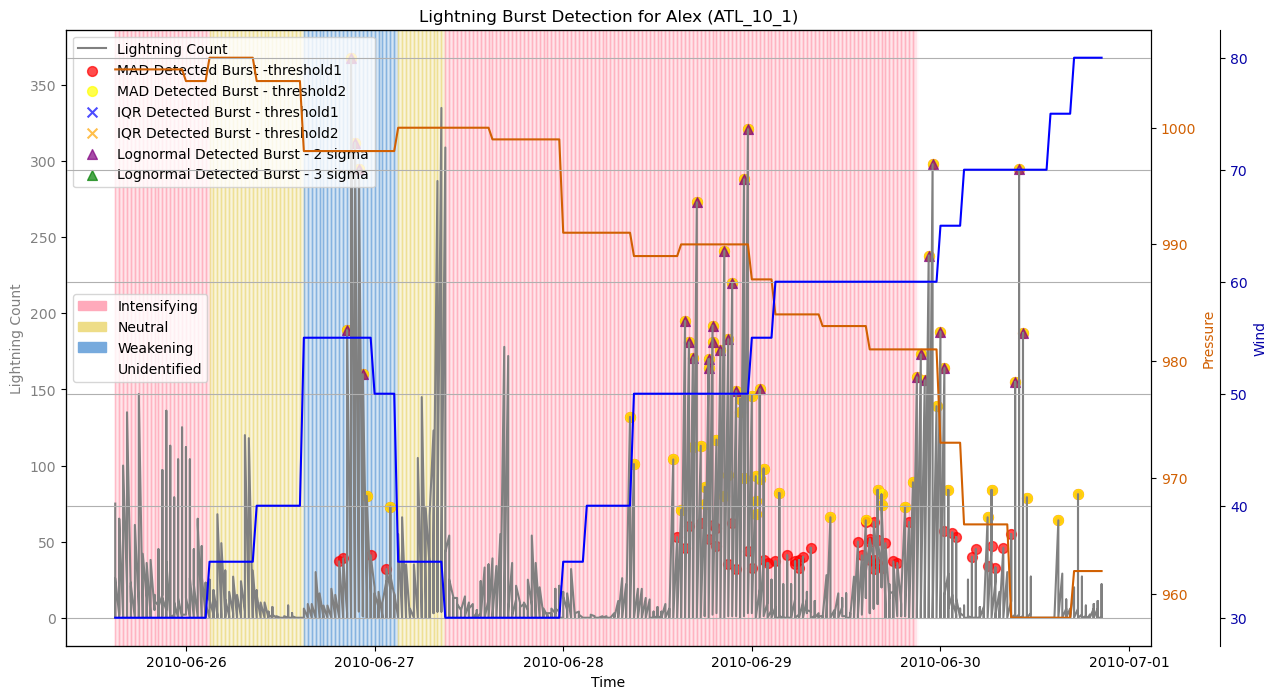

<Figure size 1000x500 with 0 Axes>

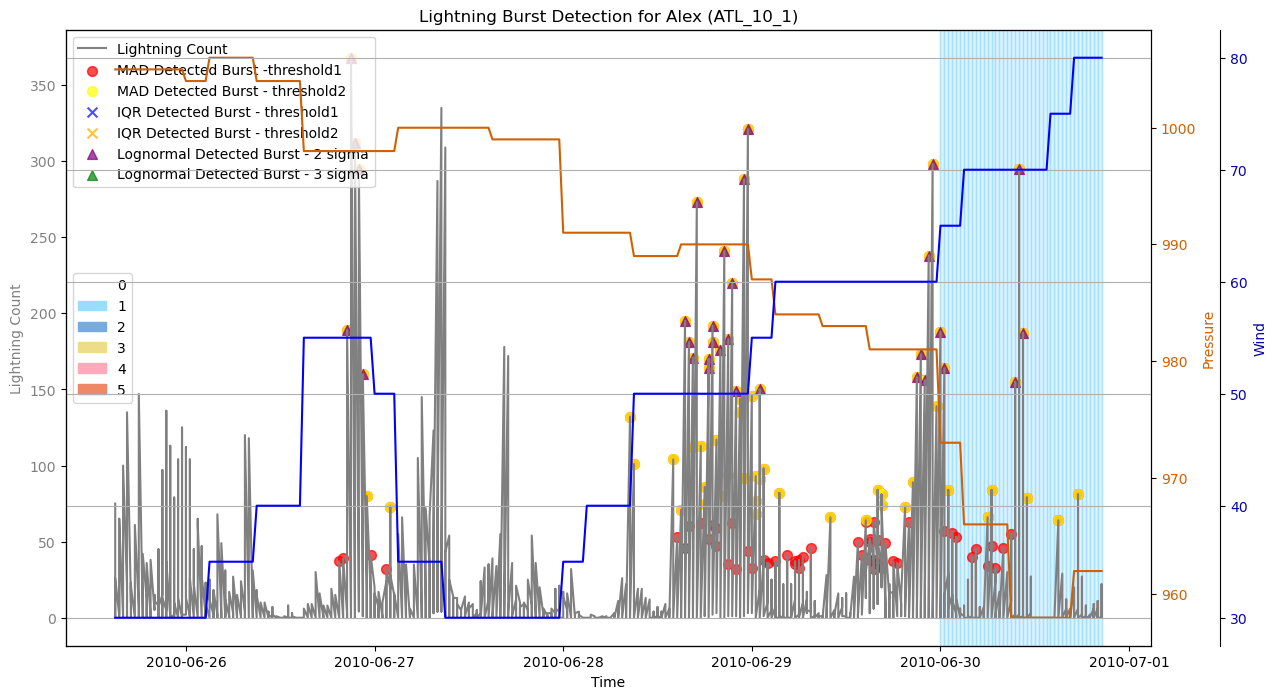

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
0   ATL_10_1          121           68        3.465736        4.158883   

   iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
0            0            0        5.914525        7.393156            31   

   logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
0             0         5.000153         6.718335         672      18.01   

   mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
0      10.12        0.0        0.0        4.61         0.0

In [25]:
# ATL_10_1 with 0 in the analysis
cyclone_id = 'ATL_10_1'

plot_tc(cyclone_id, bursts_w_0, storm_names, rainband_shear_timebin_joined, "i3")
plot_tc(cyclone_id, bursts_w_0, storm_names, rainband_shear_timebin_joined, "c5")
# Print the summary for this storm
tc_summary_w_0[tc_summary_w_0["storm_code"] == cyclone_id]

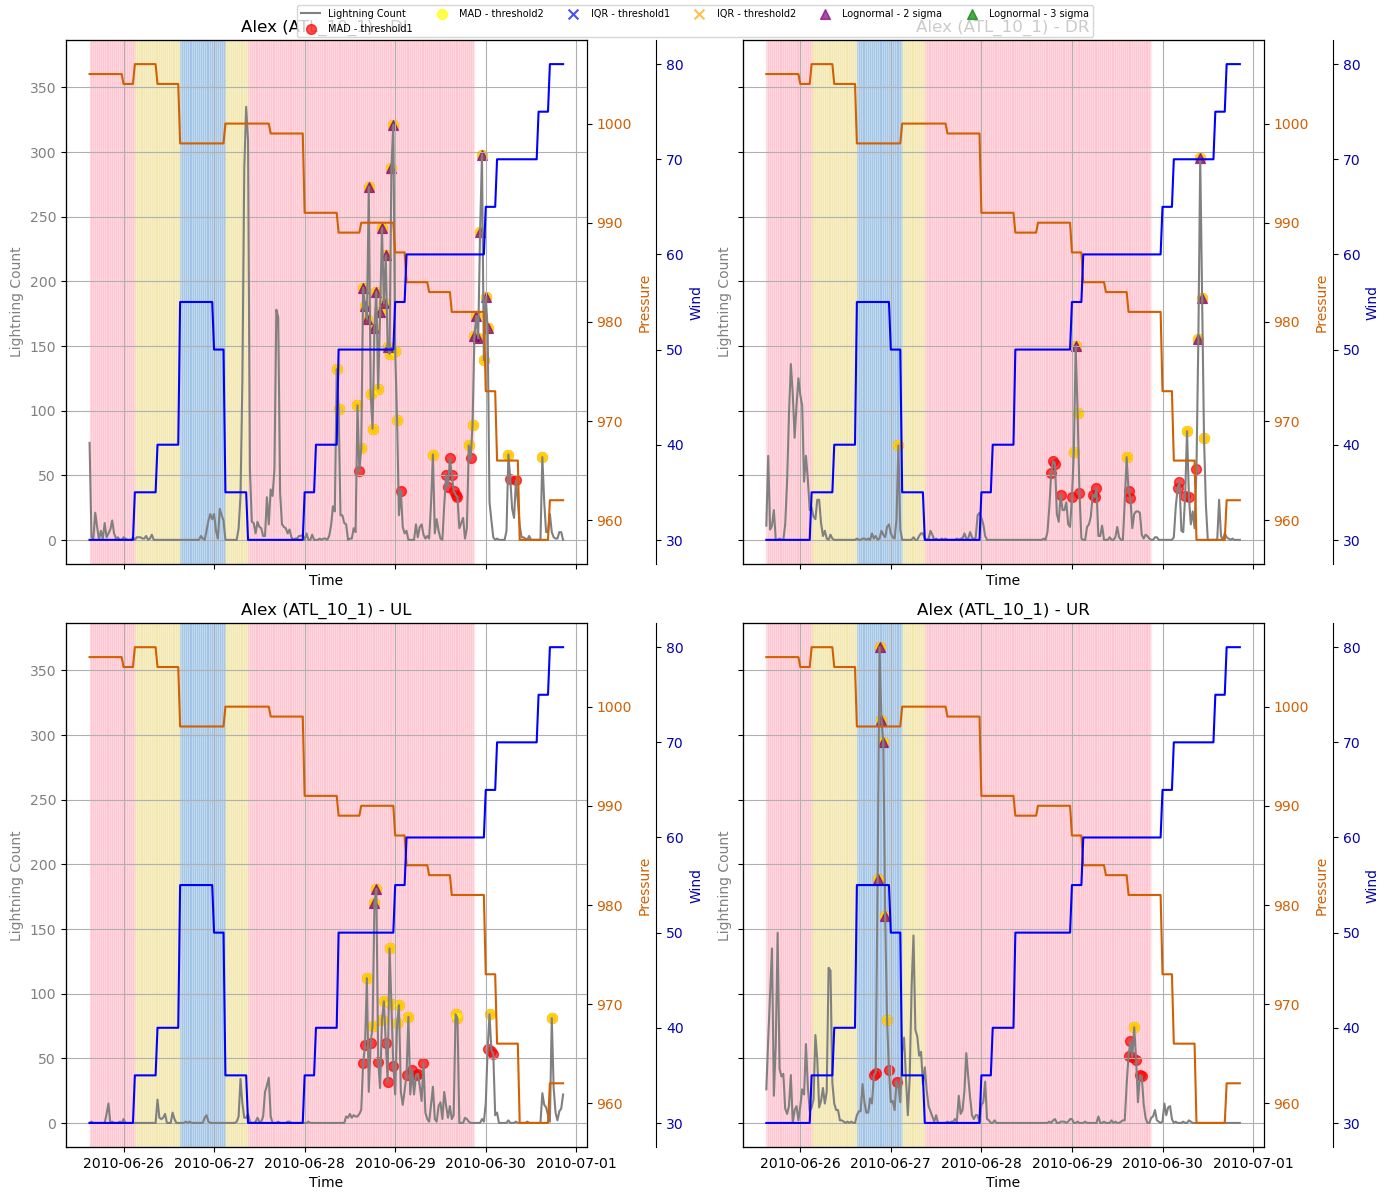

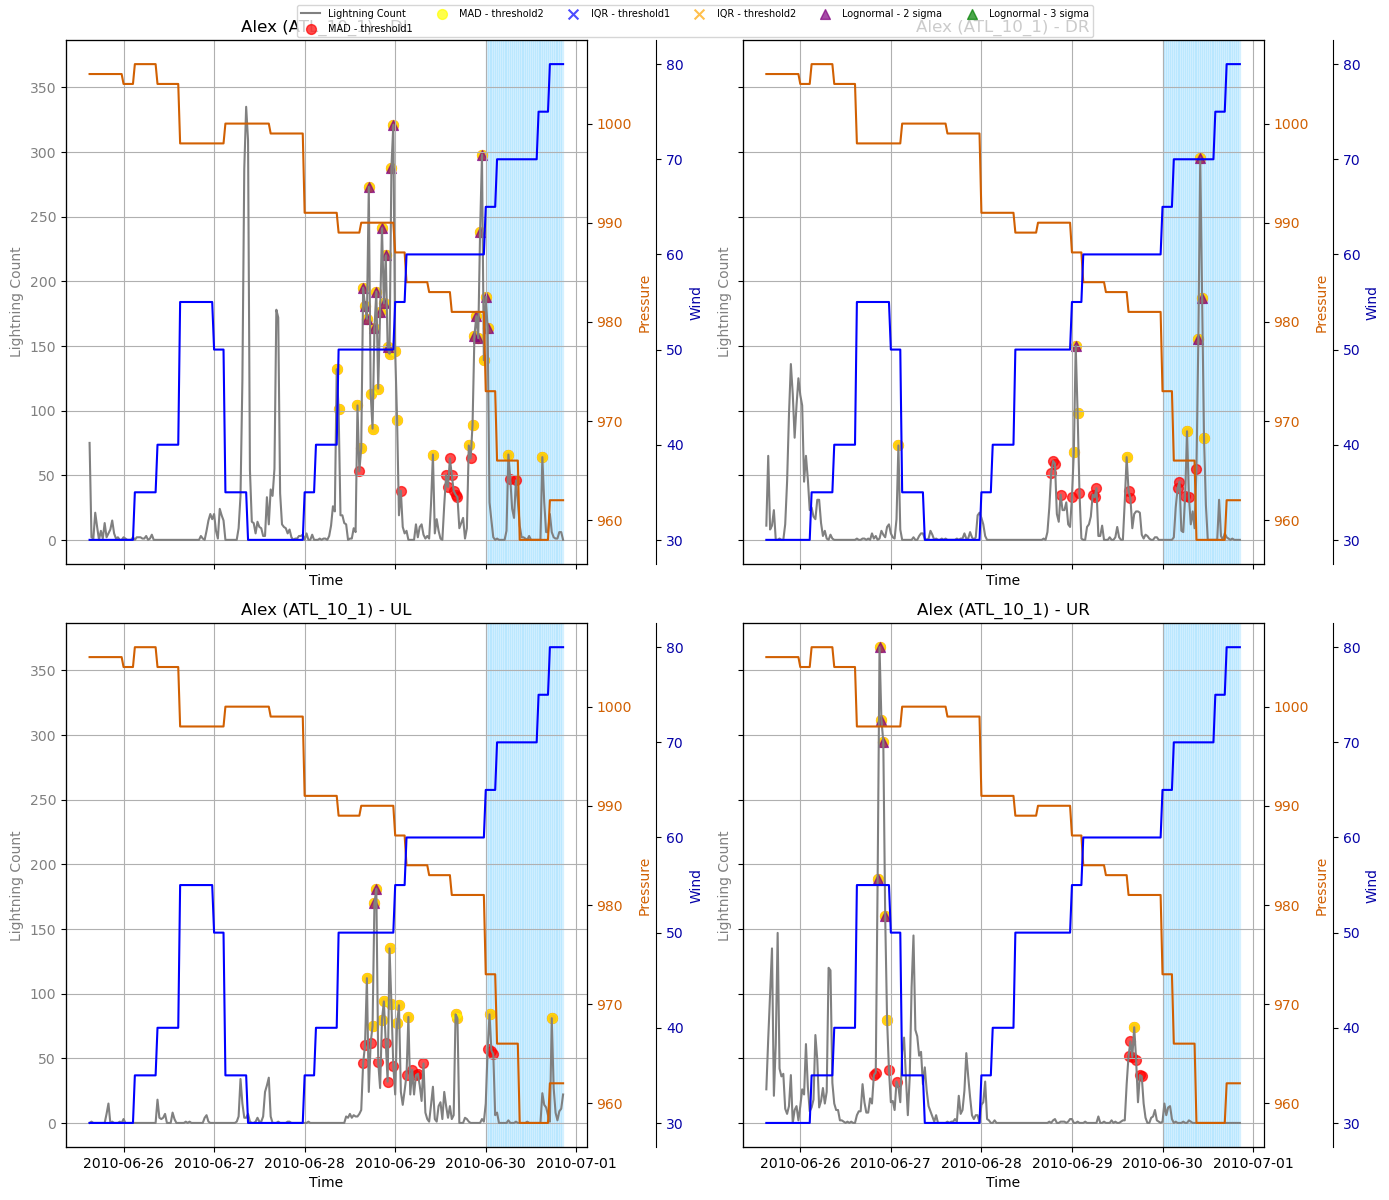

In [26]:
plot_tc_quadrants(cyclone_id, bursts_w_0, storm_names, rainband_shear_timebin_joined, "i3")
plot_tc_quadrants(cyclone_id, bursts_w_0, storm_names, rainband_shear_timebin_joined, "c5")


In [27]:
# Apply functions to data(exclude 0 lightning count)
pd_data_drop0 = pd_data[pd_data['lightning_count'] != 0]

bursts = apply_individual_thresholds(pd_data_drop0)

tc_summary = create_tc_summary(bursts)
tc_summary = pd.merge(storm_names.to_pandas(), tc_summary, on="storm_code")
tc_summary.head(10)

c:\Users\user\Desktop\GitHub\Lightning_Analysis_NWRA\lightning_burst_identification\lightning_threshold_functions.py:145: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  bursts = df.groupby(["storm_code"]).apply(detect_bursts_iqr)
c:\Users\user\Desktop\GitHub\Lightning_Analysis_NWRA\lightning_burst_identification\lightning_threshold_functions.py:147: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

storm_code storm_name  mad1_bursts  mad2_bursts  mad1_threshold  \
0  WPAC_15_23   Choi-Wan            5            3        4.158883   
1    ATL_12_5    Ernesto            0            0        7.279569   
2   ATL_11_18       Rina            0            0        7.728315   
3   ATL_17_13      Katia            0            0        9.419414   
4  SHEM_16_11    Winston            1            0        6.186209   
5    ATL_16_5       Earl            0            0        7.821164   
6  EPAC_15_17      Marty            0            0        6.526439   
7    ATL_14_7        Fay            0            0        5.274601   
8   SHEM_14_8      Colin            7            3        3.439678   
9  EPAC_14_11     Karina            7            4        4.158883   

   mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
0        4.852030           11            5        3.583519        4.306112   
1        8.458224            0            0        6.112575        7.294146   
2        8.952091            1            0        6.441265        7.649222   
3       11.153041            0            0        7.821577        9.502318   
4        7.284821           22            2        4.790266        5.713179   
5        8.971736            0            0        6.608718        7.803324   
6        7.671572           14            3        5.236216        6.270616   
7        6.190892            2            0        4.973280        6.043313   
8        3.988984            7            2        3.465736        4.158883   
9        4.852030           12            7        3.524627        4.232497   

   ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
0  ...             1         3.968462         5.098582         103       4.85   
1  ...             0         5.507069         6.952000         863       0.00   
2  ...             0         5.844321         7.338208         279       0.00   
3  ...             0         6.845091         8.824694         216       0.00   
4  ...             1         4.743776         6.064007         602       0.17   
5  ...             0         6.087467         7.573849         406       0.00   
6  ...             0         5.294359         6.803629         258       0.00   
7  ...             0         4.448071         5.700474         130       0.00   
8  ...             0         3.484035         4.441218          98       7.14   
9  ...             1         4.239918         5.509788          96       7.29   

   mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
0       2.91      10.68       4.85        5.83        0.97  
1       0.00       0.00       0.00        1.39        0.00  
2       0.00       0.36       0.00        1.08        0.00  
3       0.00       0.00       0.00        1.85        0.00  
4       0.00       3.65       0.33        3.82        0.17  
5       0.00       0.00       0.00        1.23        0.00  
6       0.00       5.43       1.16        5.04        0.00  
7       0.00       1.54       0.00        6.15        0.00  
8       3.06       7.14       2.04        7.14        0.00  
9       4.17      12.50       7.29        6.25        1.04  

[10 rows x 21 columns]

<Figure size 1000x500 with 0 Axes>

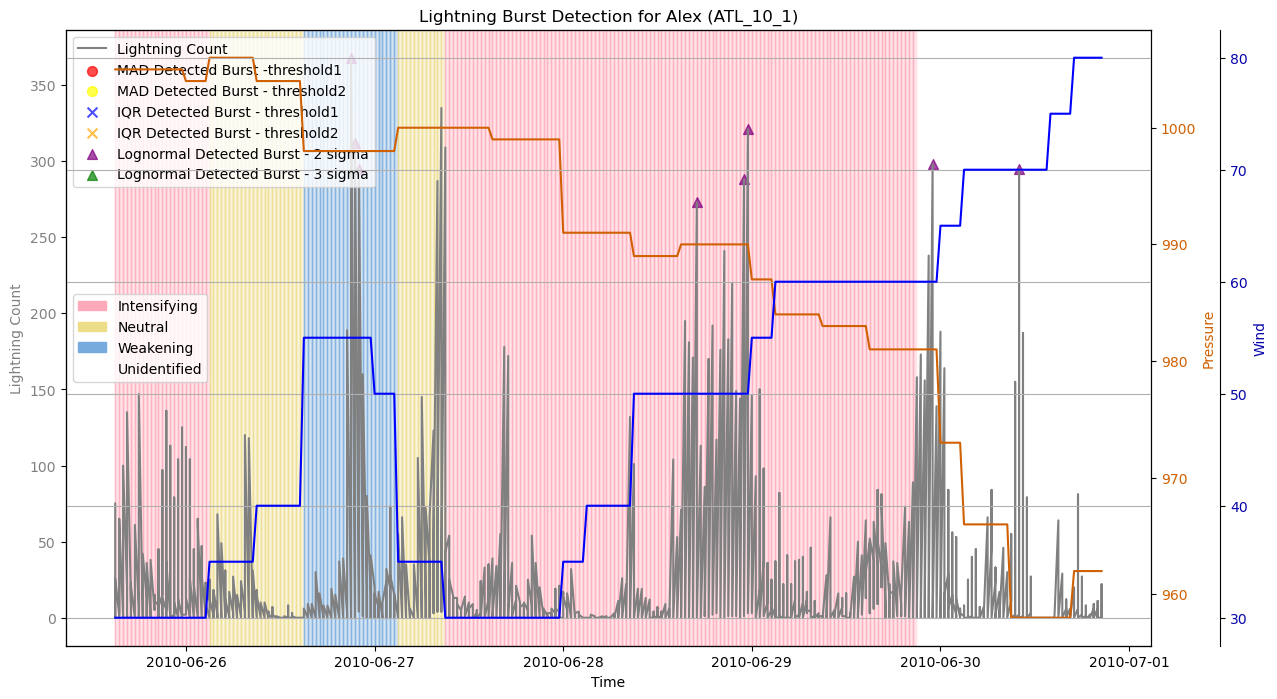

<Figure size 1000x500 with 0 Axes>

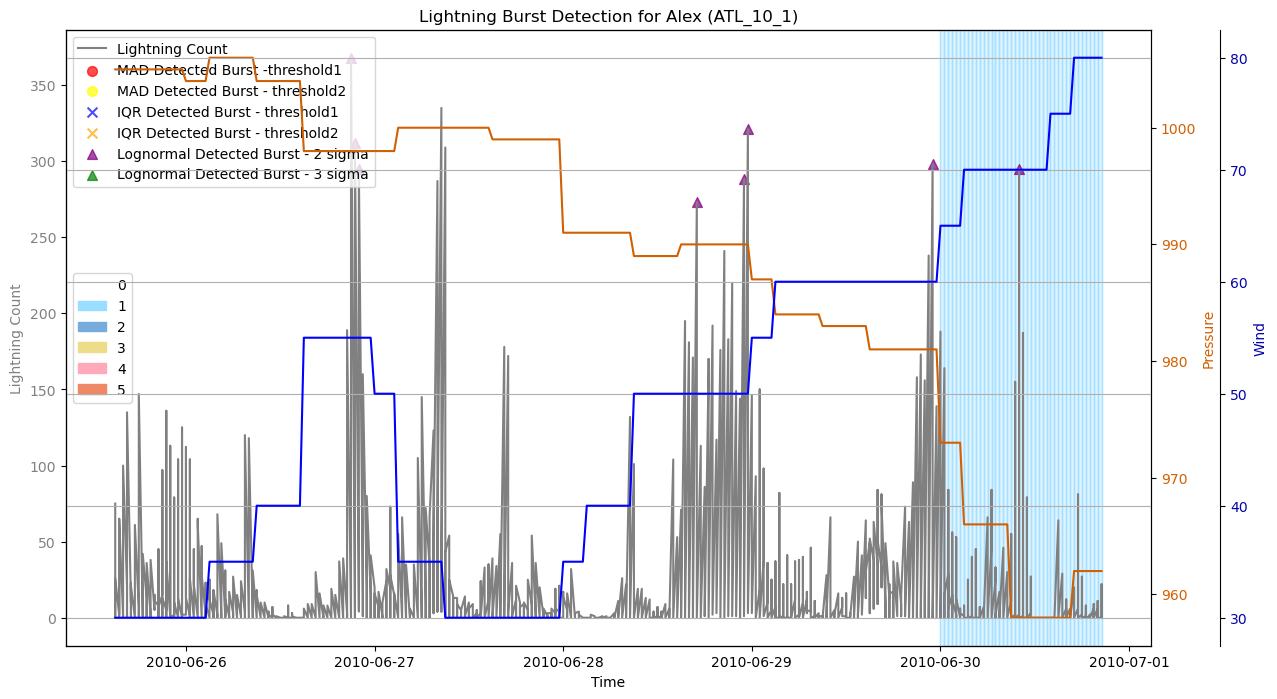

storm_code storm_name  mad1_bursts  mad2_bursts  mad1_threshold  \
227   ATL_10_1       Alex            0            0        7.397394   

     mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
227        8.586978            0            0         6.04085        7.204489   

     ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  \
227  ...             0          5.54689         6.969608         389   

     mad1_prop  mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
227        0.0        0.0        0.0        0.0        2.06         0.0  

[1 rows x 21 columns]

In [28]:
# ATL_10_1 without 0 in threshold calculation
cyclone_id = 'ATL_10_1'
plot_tc(cyclone_id, bursts, storm_names, rainband_shear_timebin_joined, "i3")
plot_tc(cyclone_id, bursts, storm_names, rainband_shear_timebin_joined, "c5")
# Print the summary for this storm
tc_summary[tc_summary["storm_code"] == cyclone_id]

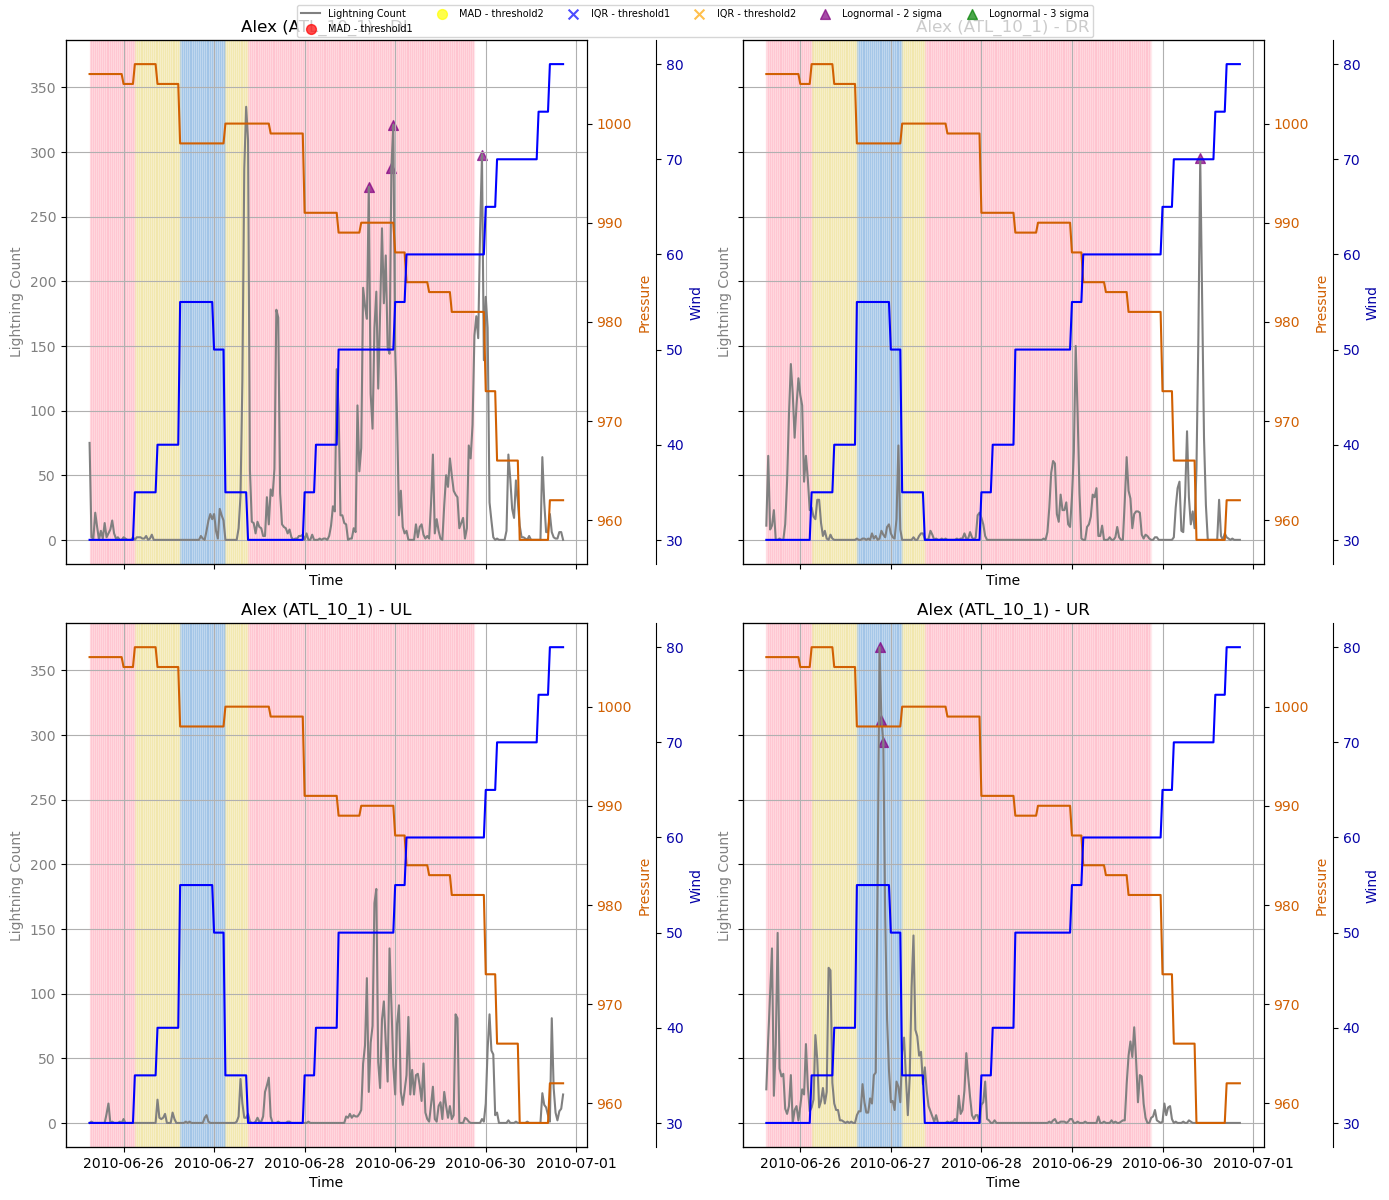

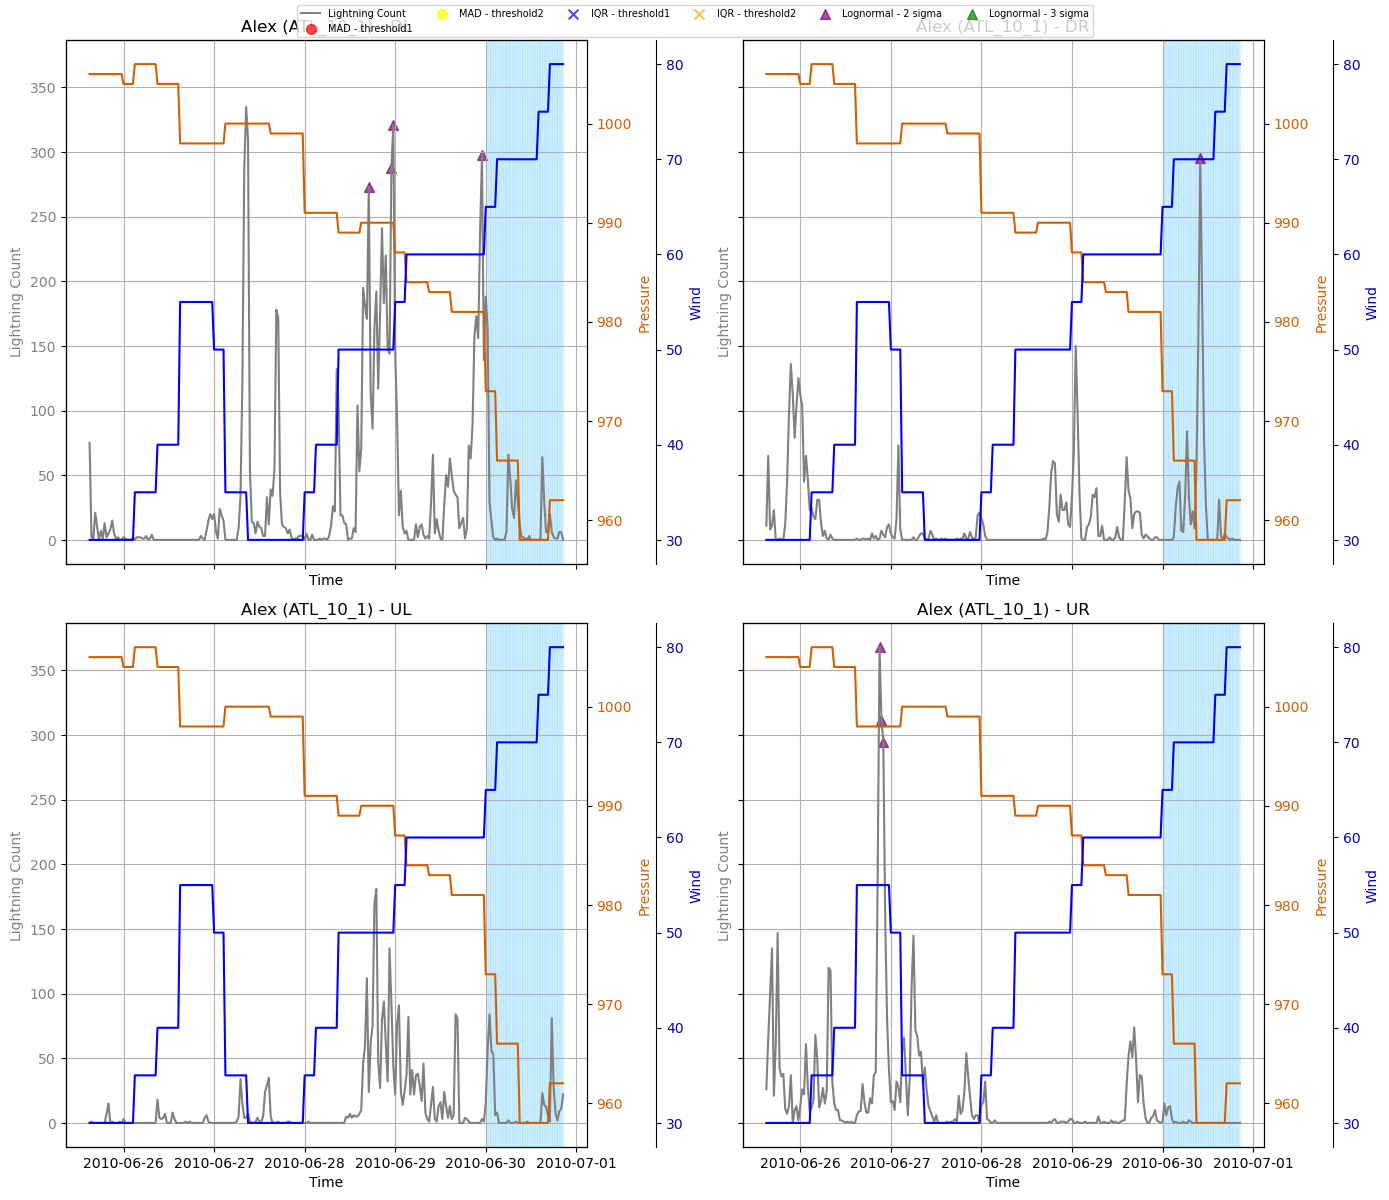

In [29]:
plot_tc_quadrants(cyclone_id, bursts, storm_names, rainband_shear_timebin_joined, "i3")
plot_tc_quadrants(cyclone_id, bursts, storm_names, rainband_shear_timebin_joined, "c5")


In [30]:
rainband_shear_timebin_joined_pd = rainband_shear_timebin_joined.to_pandas()
filtered_df = rainband_shear_timebin_joined_pd[rainband_shear_timebin_joined_pd['storm_code'].str.contains('^EPAC')]
filtered_df

time_bin shear_quad storm_code  lightning_count  year  \
78400  2010-06-18 15:00:00         DL  EPAC_10_4                0  2010   
78401  2010-06-18 15:00:00         DR  EPAC_10_4                0  2010   
78402  2010-06-18 15:00:00         UL  EPAC_10_4                3  2010   
78403  2010-06-18 15:00:00         UR  EPAC_10_4                0  2010   
78404  2010-06-18 15:30:00         DL  EPAC_10_4                0  2010   
...                    ...        ...        ...              ...   ...   
139647 2017-07-29 01:00:00         UR  EPAC_17_9                0  2017   
139648 2017-07-29 01:30:00         DL  EPAC_17_9                0  2017   
139649 2017-07-29 01:30:00         DR  EPAC_17_9                0  2017   
139650 2017-07-29 01:30:00         UL  EPAC_17_9                1  2017   
139651 2017-07-29 01:30:00         UR  EPAC_17_9                0  2017   

        month  day  hour  minute   lat  ...  knots  storm_name  category  \
78400       6   18    15       0  13.2  ...     25       Celia         5   
78401       6   18    15       0  13.2  ...     25       Celia         5   
78402       6   18    15       0  13.2  ...     25       Celia         5   
78403       6   18    15       0  13.2  ...     25       Celia         5   
78404       6   18    15      30  13.2  ...     25       Celia         5   
...       ...  ...   ...     ...   ...  ...    ...         ...       ...   
139647      7   29     1       0  20.0  ...     55      Hilary         2   
139648      7   29     1      30  20.0  ...     55      Hilary         2   
139649      7   29     1      30  20.0  ...     55      Hilary         2   
139650      7   29     1      30  20.0  ...     55      Hilary         2   
139651      7   29     1      30  20.0  ...     55      Hilary         2   

       basin  24_hour_knots_diff 24_hour_pressure_diff  Current_Category  \
78400   EPAC                15.0                  -8.0                 0   
78401   EPAC                15.0                  -8.0                 0   
78402   EPAC                15.0                  -8.0                 0   
78403   EPAC                15.0                  -8.0                 0   
78404   EPAC                15.0                  -8.0                 0   
...      ...                 ...                   ...               ...   
139647  EPAC                 NaN                   NaN                 0   
139648  EPAC                 NaN                   NaN                 0   
139649  EPAC                 NaN                   NaN                 0   
139650  EPAC                 NaN                   NaN                 0   
139651  EPAC                 NaN                   NaN                 0   

        Intensification_Category_5 log_lightning_count  \
78400                 Intensifying            0.000000   
78401                 Intensifying            0.000000   
78402                 Intensifying            1.386294   
78403                 Intensifying            0.000000   
78404                 Intensifying            0.000000   
...                            ...                 ...   
139647                Unidentified            0.000000   
139648                Unidentified            0.000000   
139649                Unidentified            0.000000   
139650                Unidentified            0.693147   
139651                Unidentified            0.000000   

       Intensification_Category_3  
78400                Intensifying  
78401                Intensifying  
78402                Intensifying  
78403                Intensifying  
78404                Intensifying  
...                           ...  
139647               Unidentified  
139648               Unidentified  
139649               Unidentified  
139650               Unidentified  
139651               Unidentified  

[61252 rows x 22 columns]

<Figure size 1000x500 with 0 Axes>

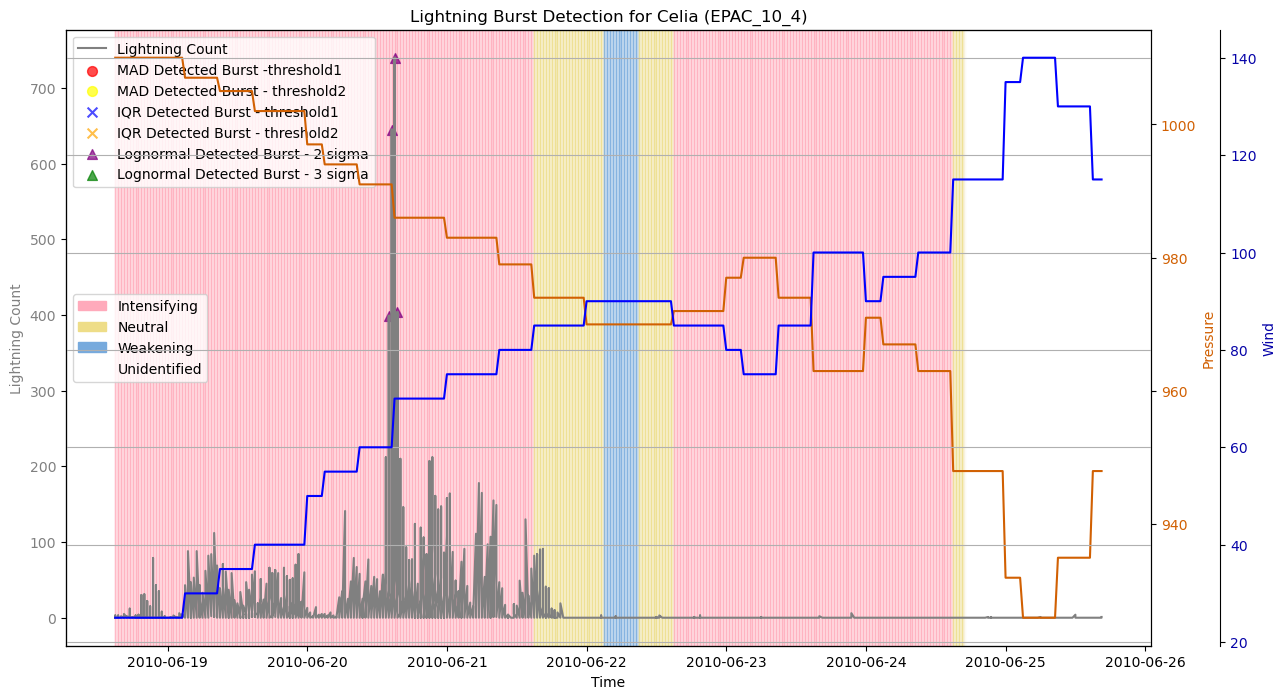

<Figure size 1000x500 with 0 Axes>

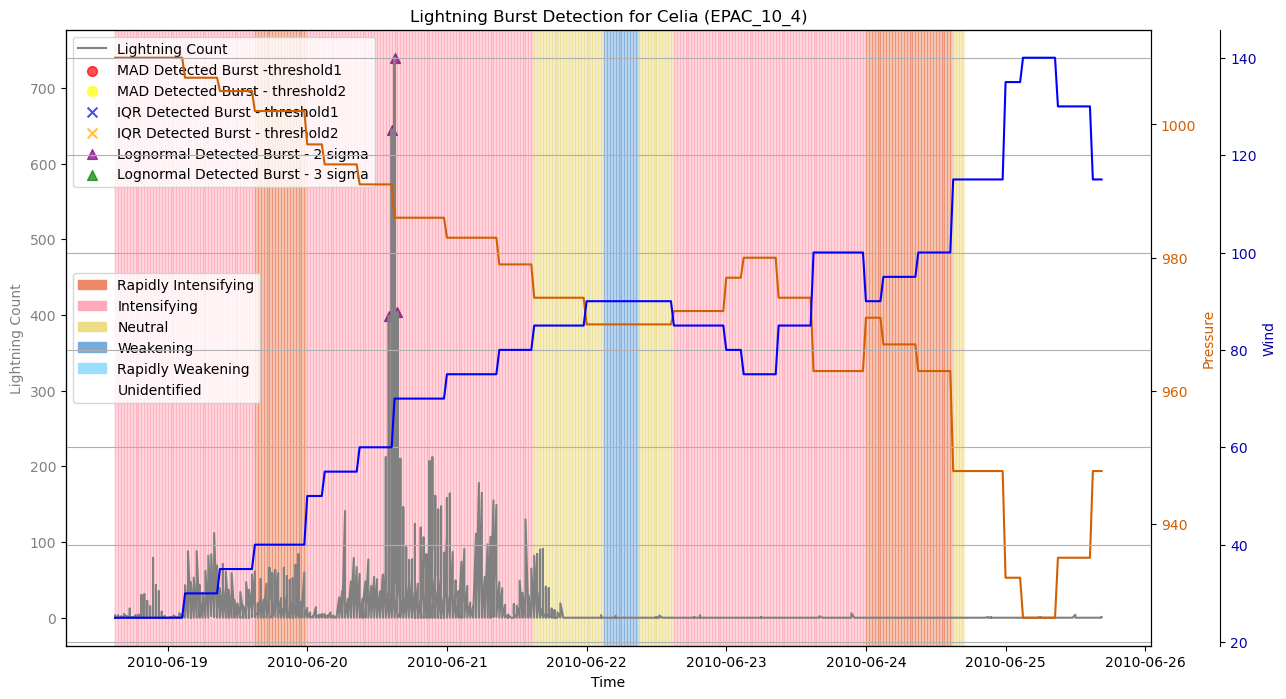

<Figure size 1000x500 with 0 Axes>

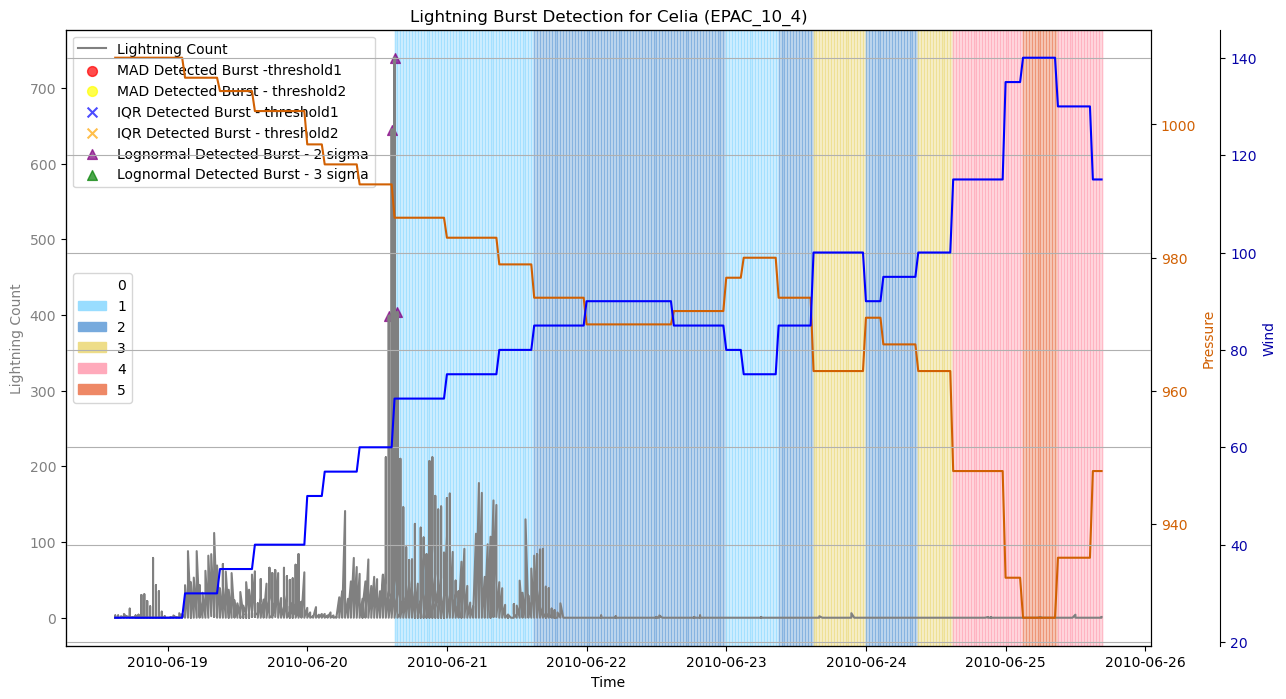

storm_code storm_name  mad1_bursts  mad2_bursts  mad1_threshold  \
49  EPAC_10_4      Celia            0            0        8.020353   

    mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
49        9.241567            0            0        6.768781        8.114402   

    ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  \
49  ...             0          5.89286         7.389035         229   

    mad1_prop  mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
49        0.0        0.0        0.0        0.0        1.75         0.0  

[1 rows x 21 columns]

In [31]:
# EPAC_18_16 - Norman
cyclone_id = 'EPAC_10_4'
plot_tc(cyclone_id, bursts, storm_names, rainband_shear_timebin_joined, "i3")
plot_tc(cyclone_id, bursts, storm_names, rainband_shear_timebin_joined, "i5")
plot_tc(cyclone_id, bursts, storm_names, rainband_shear_timebin_joined, "c5")
# Print the summary for this storm
tc_summary[tc_summary["storm_code"] == cyclone_id]

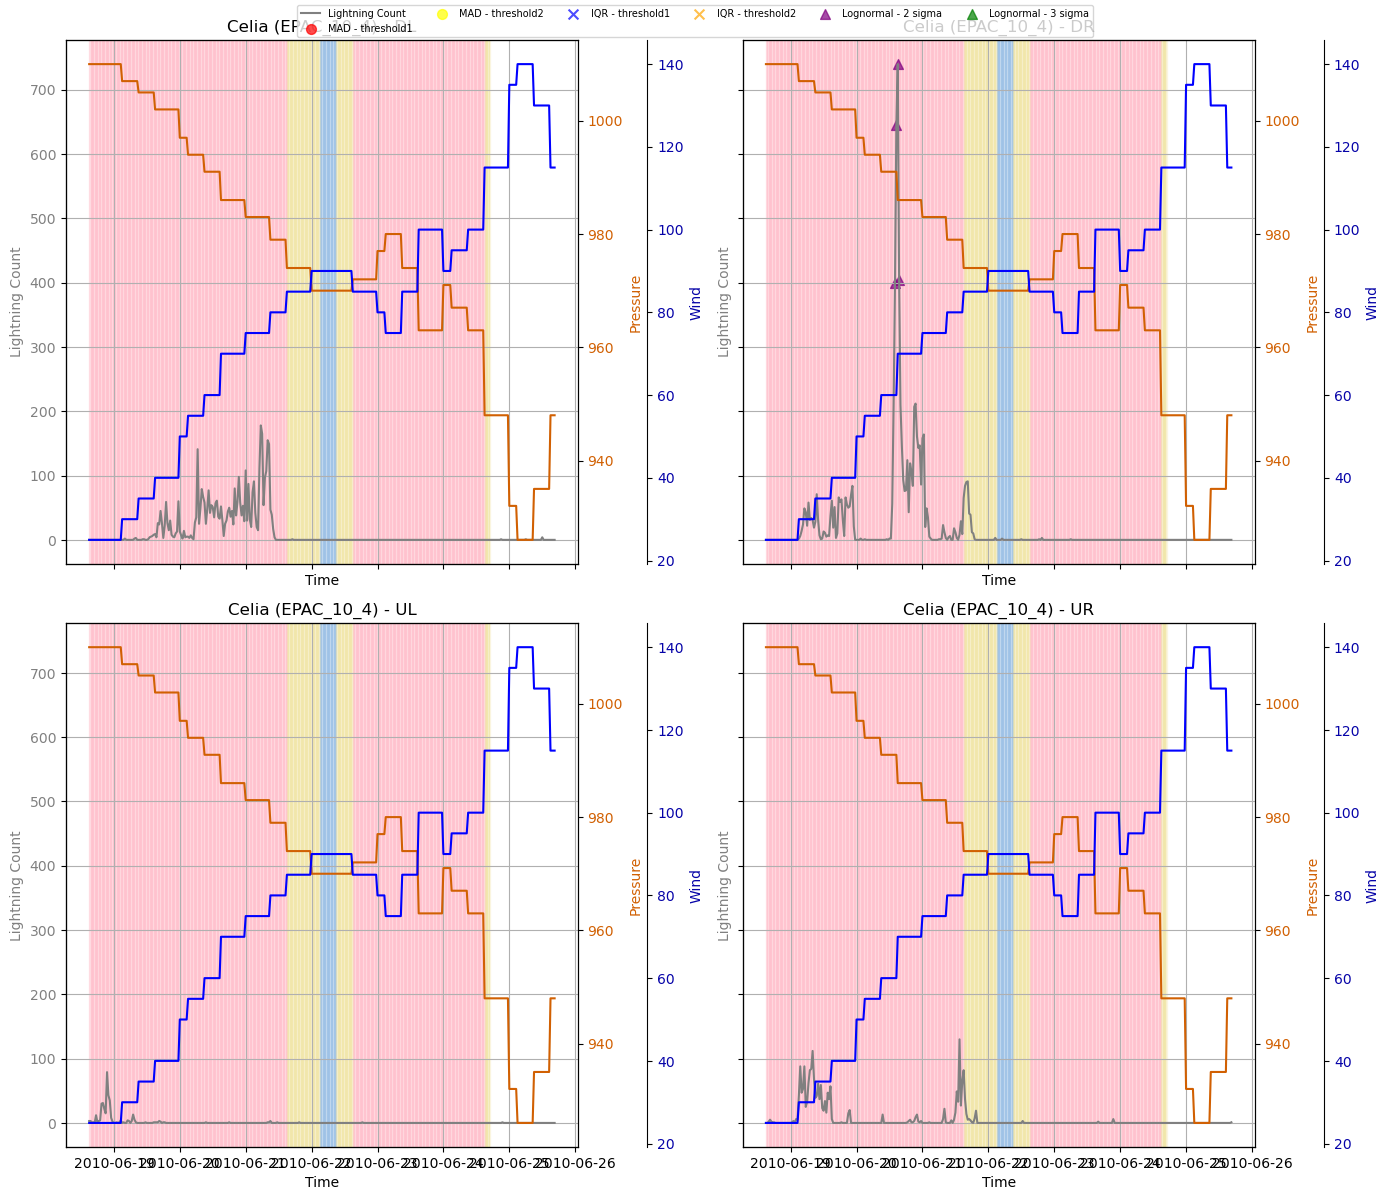

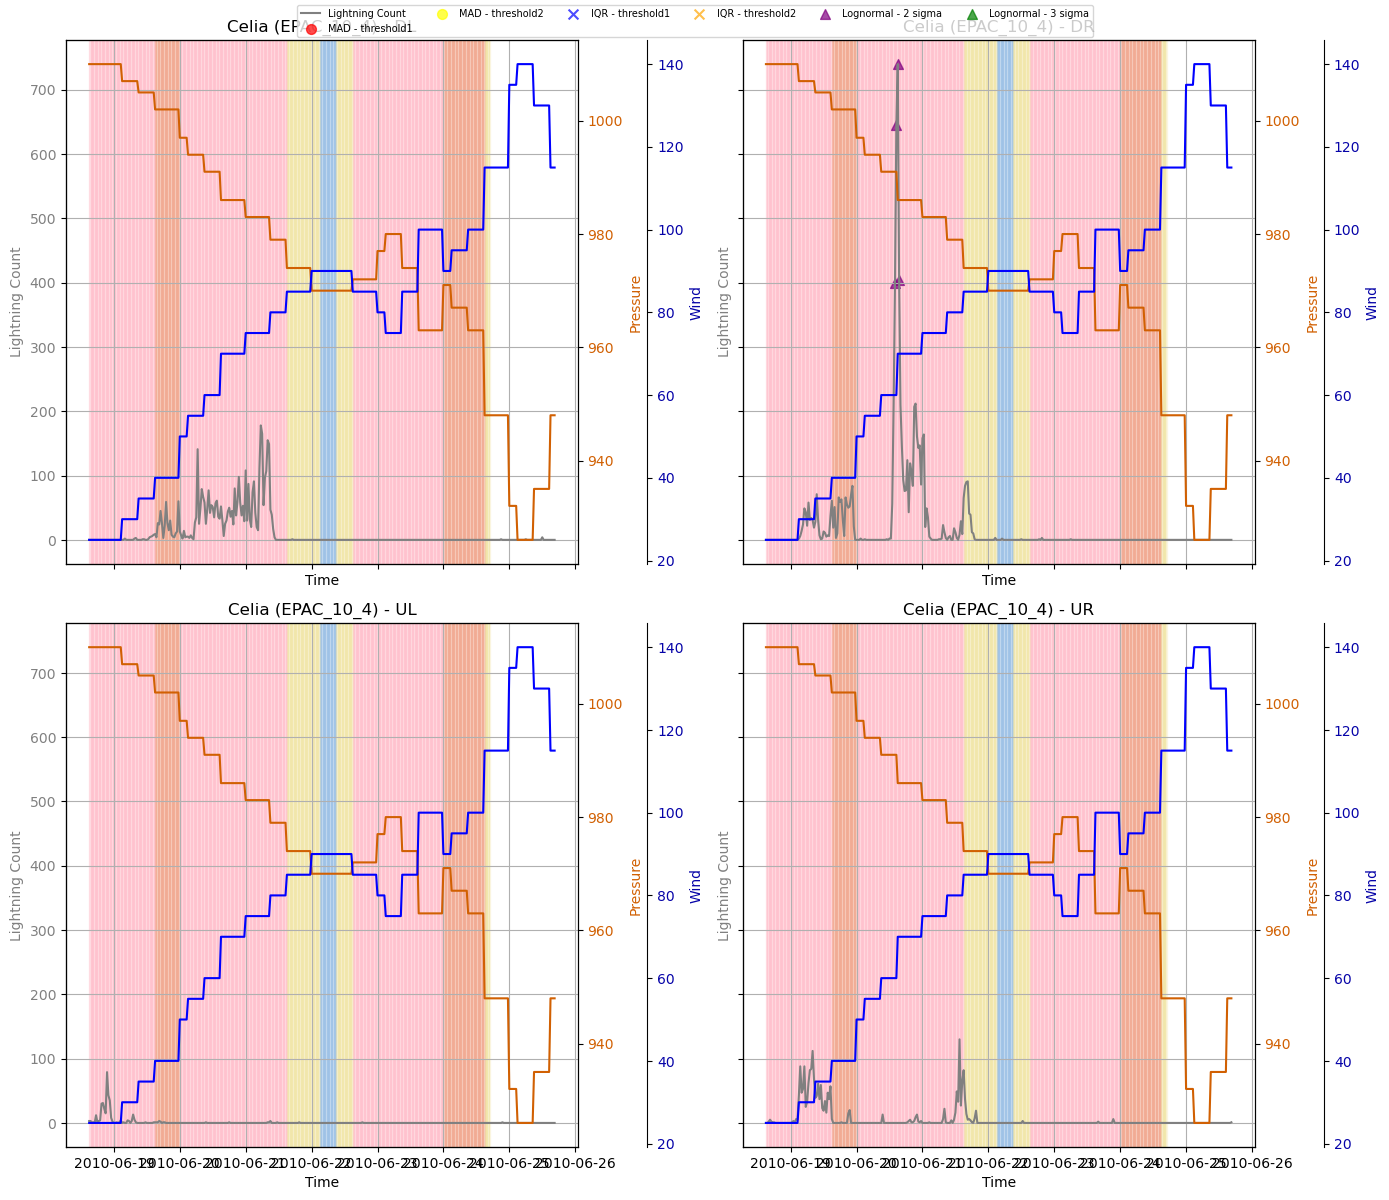

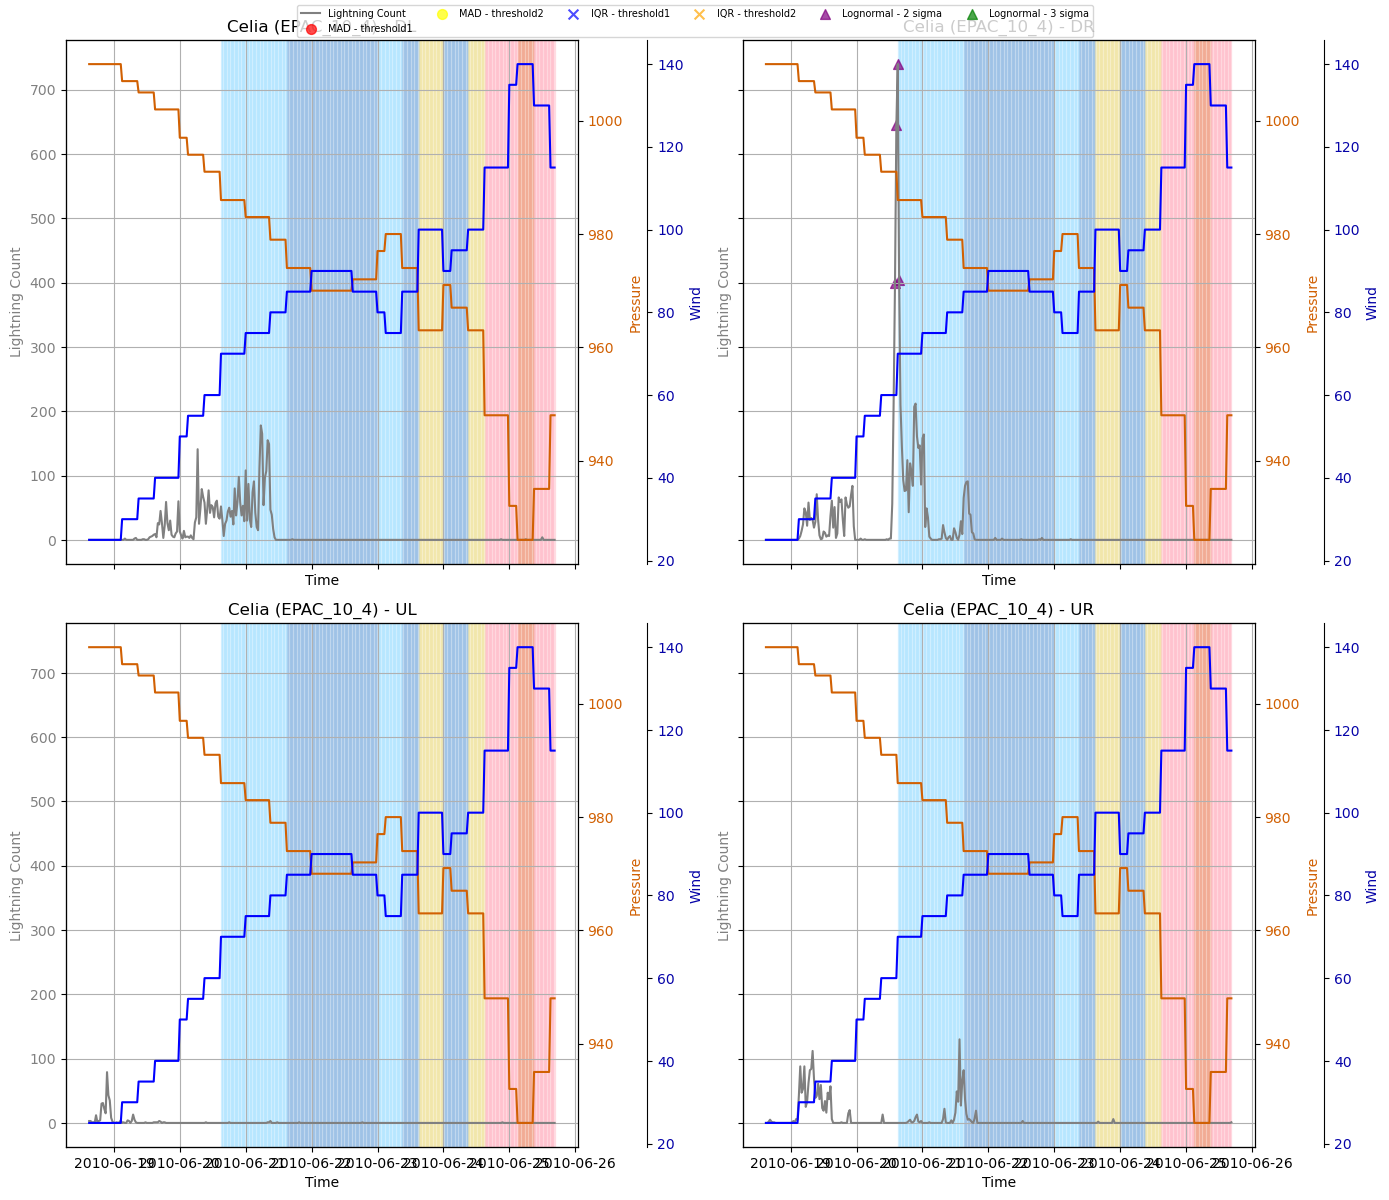

In [32]:
plot_tc_quadrants(cyclone_id, bursts, storm_names, rainband_shear_timebin_joined, "i3")
plot_tc_quadrants(cyclone_id, bursts, storm_names, rainband_shear_timebin_joined, "i5")

plot_tc_quadrants(cyclone_id, bursts, storm_names, rainband_shear_timebin_joined, "c5")


<Figure size 1000x500 with 0 Axes>

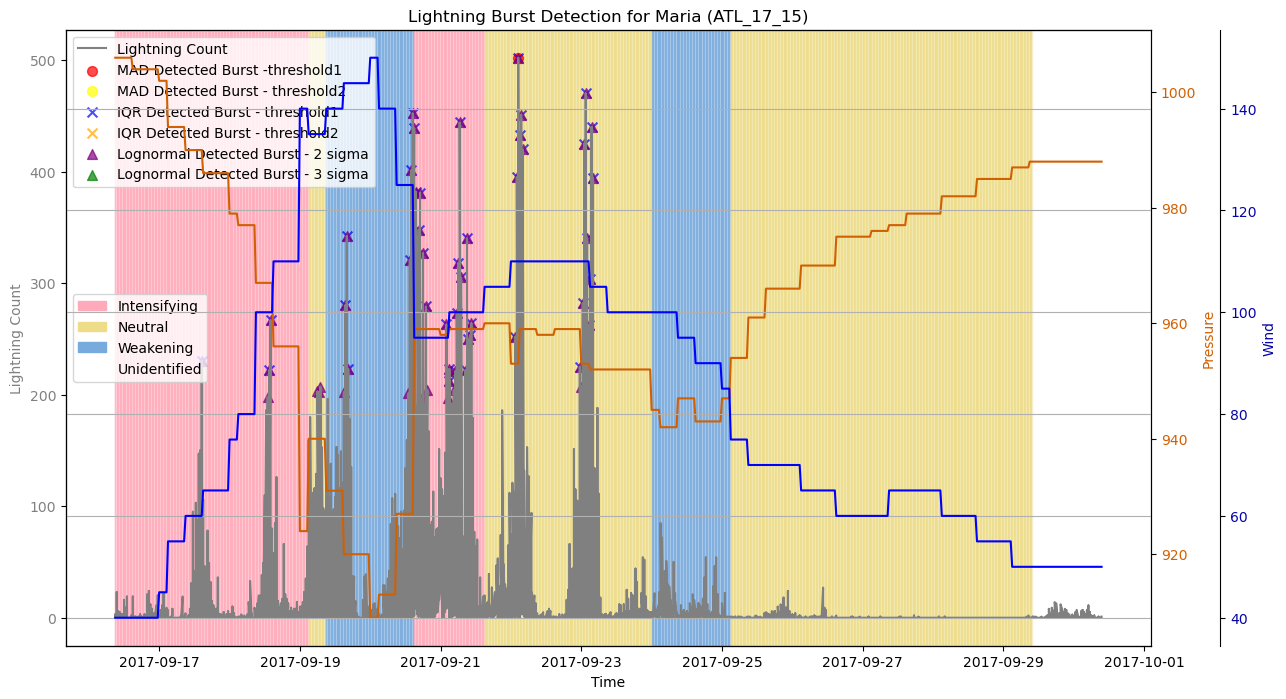

<Figure size 1000x500 with 0 Axes>

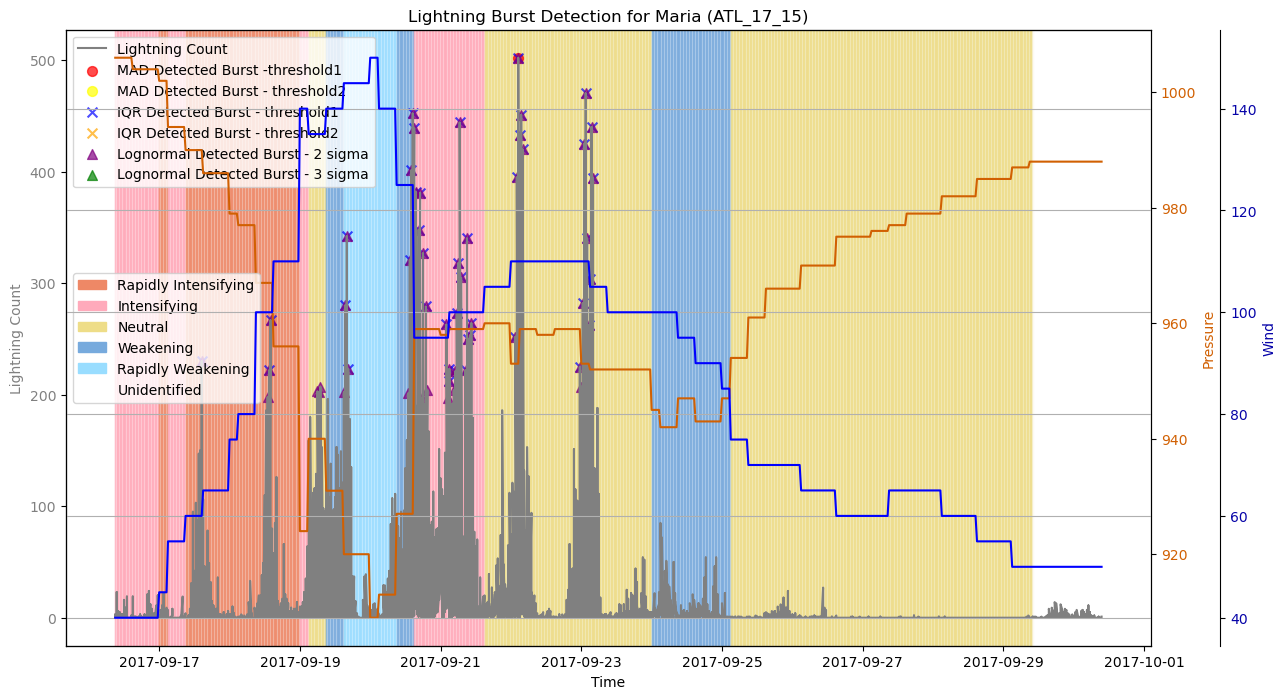

<Figure size 1000x500 with 0 Axes>

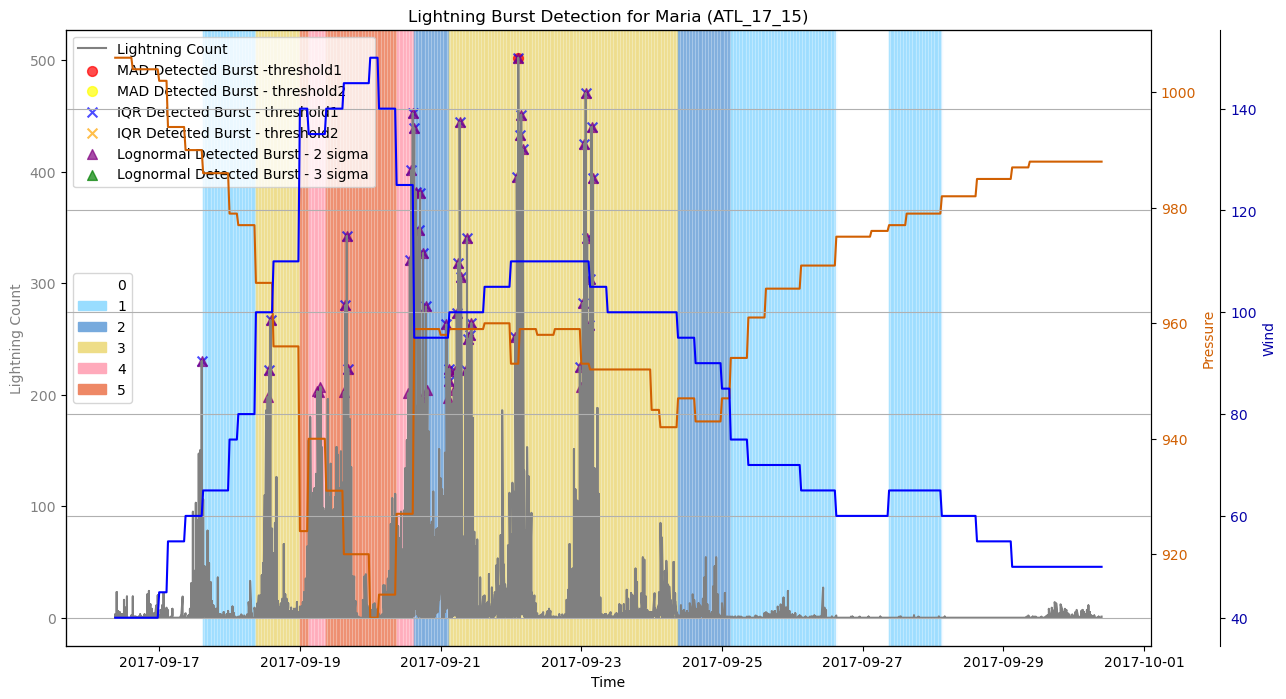

storm_code storm_name  mad1_bursts  mad2_bursts  mad1_threshold  \
75  ATL_17_15      Maria            1            0        6.186209   

    mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
75        7.284821           43            0        5.339139        6.399271   

    ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  \
75  ...             0         5.283362         6.780531        1045   

    mad1_prop  mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
75        0.1        0.0       4.11        0.0        5.17         0.0  

[1 rows x 21 columns]

In [33]:
# ATL_17_15 - Maria
cyclone_id = 'ATL_17_15'
plot_tc(cyclone_id, bursts, storm_names, rainband_shear_timebin_joined, "i3")
plot_tc(cyclone_id, bursts, storm_names, rainband_shear_timebin_joined, "i5")
plot_tc(cyclone_id, bursts, storm_names, rainband_shear_timebin_joined, "c5")
# Print the summary for this storm
tc_summary[tc_summary["storm_code"] == cyclone_id]

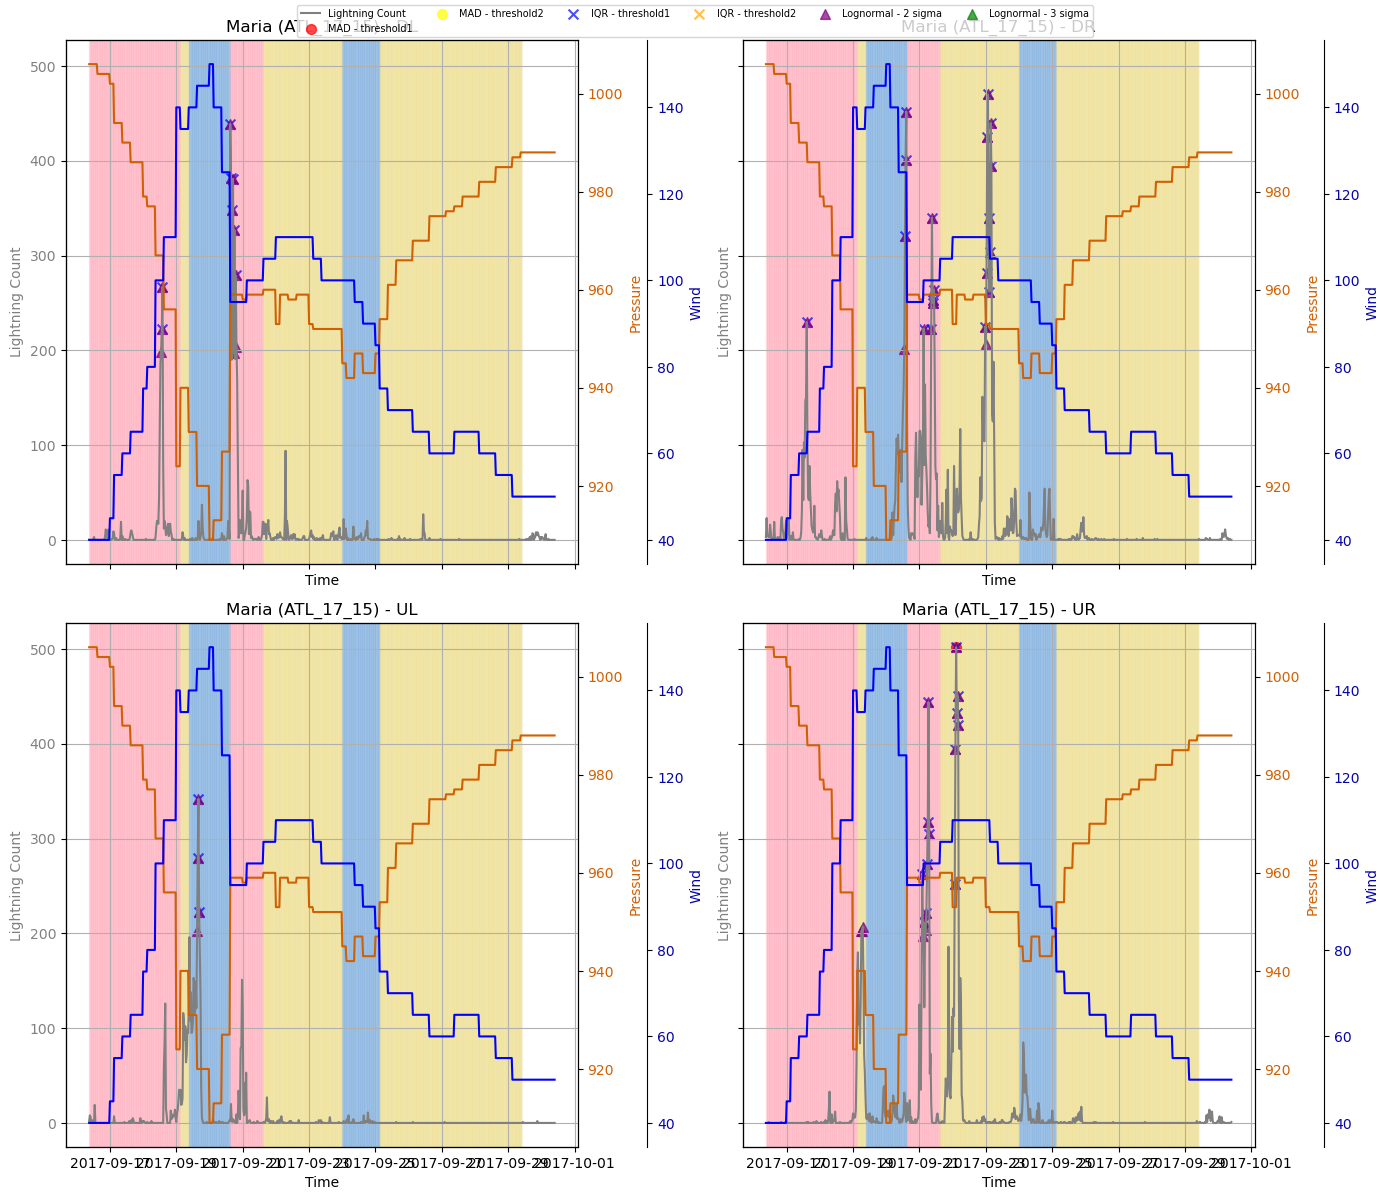

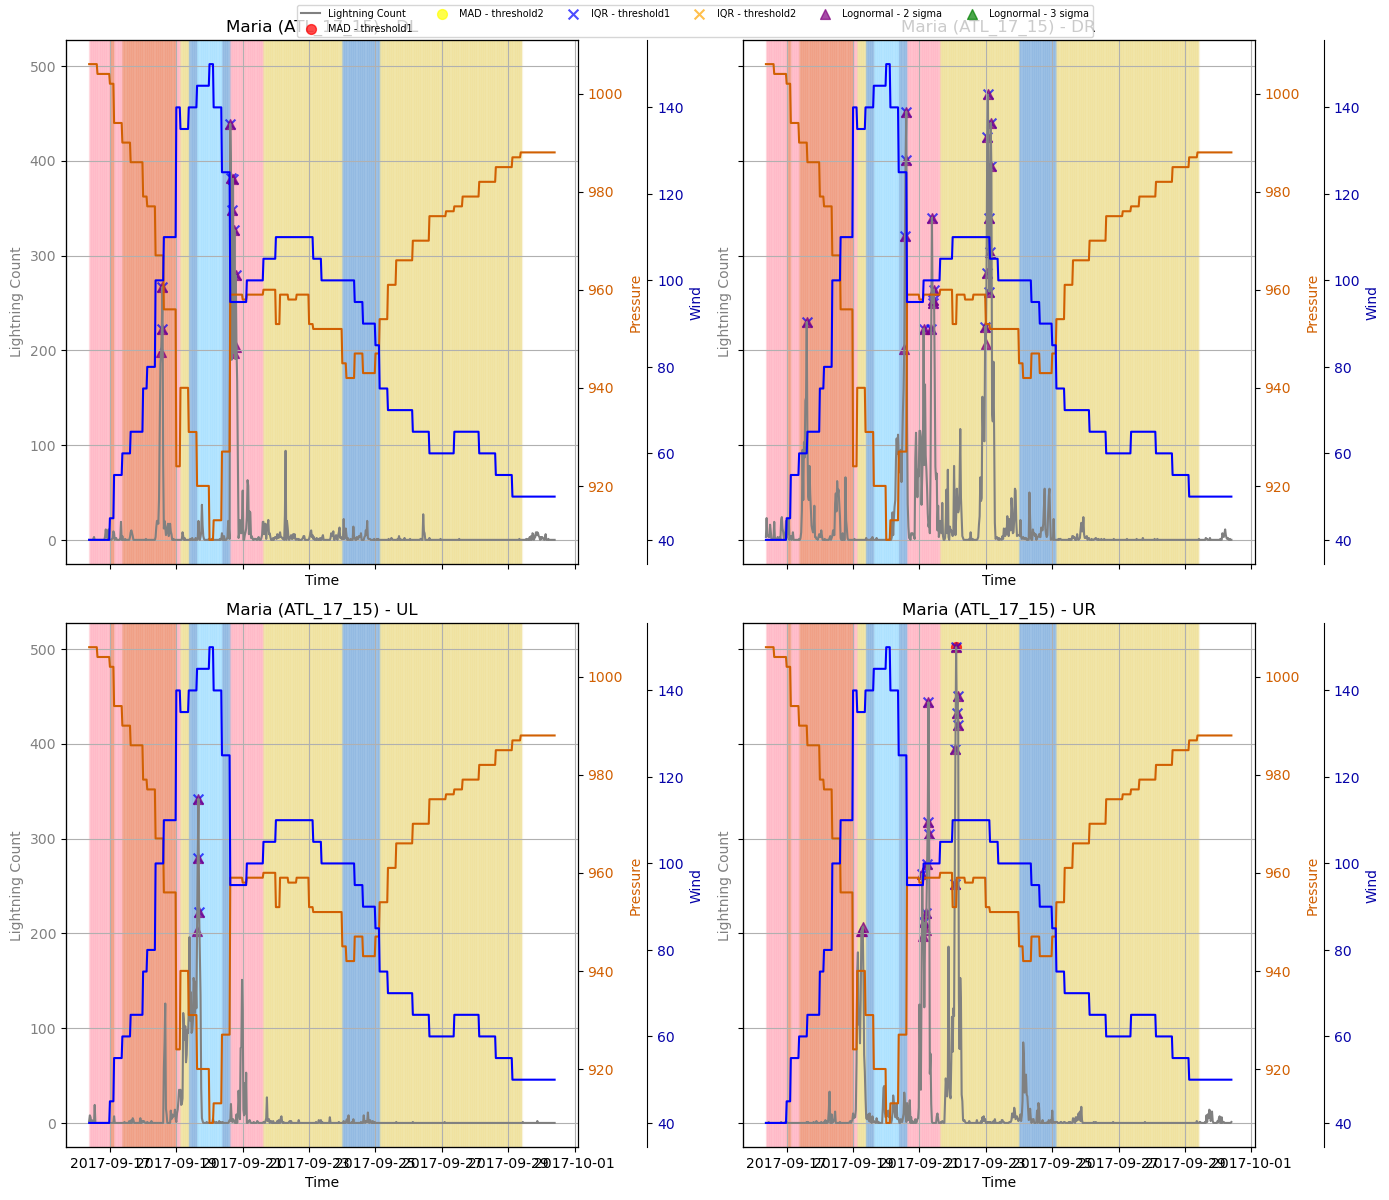

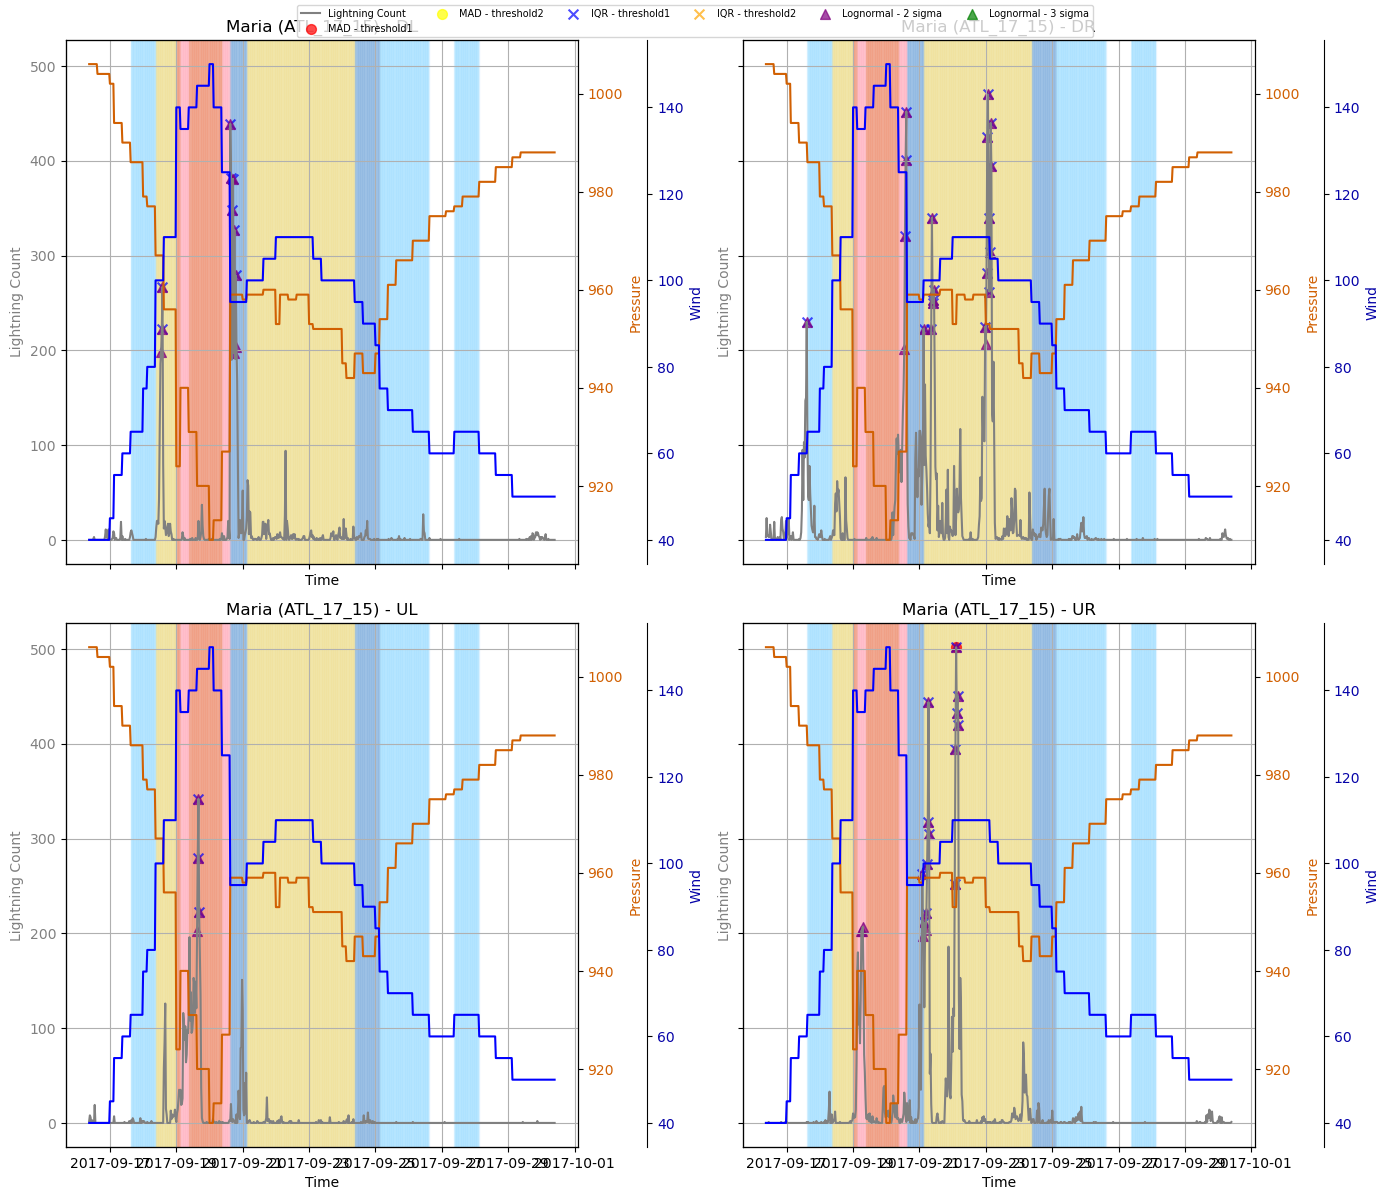

In [34]:
plot_tc_quadrants(cyclone_id, bursts, storm_names, rainband_shear_timebin_joined, "i3")
plot_tc_quadrants(cyclone_id, bursts, storm_names, rainband_shear_timebin_joined, "i5")

plot_tc_quadrants(cyclone_id, bursts, storm_names, rainband_shear_timebin_joined, "c5")


In [35]:
# Export for external tool vis
# marker - rename files?

print('export originally here')
# innercore_data.write_csv("vis_data/tc_lightning_vis_data.csv")
# tc_summary.to_csv("vis_data/threshold_summary.csv")
# bursts.to_csv("vis_data/tc_threshold.csv")

export originally here


In [36]:
# Define threshold names for use later
threshold_names = {
    'mad1':['mad1_threshold','MAD1'],
    'mad2':['mad2_threshold','MAD2'],
    'iqr1':['iqr1_threshold','IQR1'],
    'iqr2':['iqr2_threshold','IQR2'],
    'logn1':['logn1_threshold','Lognormal 2 Sigma'],
    'logn2':['logn2_threshold','Lognormal 3 Sigma'],
}
threshold_keys = list(threshold_names.keys())
threshold_cols = [threshold_names[key][0] for key in threshold_keys]
threshold_labels = [threshold_names[key][1] for key in threshold_keys]

In [37]:
# No bursts detected
# marker - need to look into why the agg result dataframes are not the same length??
selected_columns = ["mad1_bursts", "mad2_bursts", "iqr1_bursts", "iqr2_bursts", "logn1_bursts", "logn2_bursts"]
print(f"{(tc_summary_w_0[selected_columns].sum(axis=1) == 0).sum()} TCs of {len(tc_summary_w_0)} TCs with no bursts detected across all 6 threshold methods for analysis including 0 count timebins.")
no_bursts = tc_summary[tc_summary[selected_columns].sum(axis=1) == 0]
print(f"{len(no_bursts)} TCs of {len(tc_summary)} TCs with no bursts detected across all 6 threshold methods for analysis without 0 count timebins.")

1 TCs of 303 TCs with no bursts detected across all 6 threshold methods for analysis including 0 count timebins.
22 TCs of 303 TCs with no bursts detected across all 6 threshold methods for analysis without 0 count timebins.
